In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import polars as pl
from sklearn.model_selection import train_test_split
from interpret import show
from interpret.perf import ROC

from interpret import set_visualize_provider
from interpret.provider import InlineProvider
set_visualize_provider(InlineProvider())

In [ ]:
from ml.data import load_spy_sample, load_vix, add_last_close_pct
from ml.utils import by_date, train_holdout_dates

class DataLoader:
    def __init__(self, months=[1], sample_fraction=None):
        df = load_spy_sample(months=months)

        # Cutoff
        #df = df.filter(pl.col('minute_index') <= 300)

        if sample_fraction:
            df = df.sample(fraction=sample_fraction, seed=42)

        print(f"Loaded {len(df):,} samples ({df['symbol'].n_unique():,} series)")

        self.df = df
        self.pre_process()

    def pre_process(self):
        df = self.df

        df = df.filter(pl.col('option_type') == 'P')

        df = df.with_columns(df['option_type'].cast(pl.Categorical))

        df = add_last_close_pct(df)

        # Moneyness is underlying / strike e.g. 0.95 is 5% otm
        df = df.filter((pl.col('close_moneyness') > 0.97) & (pl.col('close_moneyness') < 1.01))

        # Low amount of data here
        df = df.filter(pl.col('close') < 3)

        # Doesn't hit stop
        df = df.with_columns((pl.col('max_forward_return') < 1.0).alias('stop_not_hit'))

        # Is worth less than sell price at close
        df = df.with_columns((pl.col('last_close_pct') < 0.0).alias('close_decreased'))

        df = df.with_columns(((pl.col('stop_not_hit') & pl.col('close_decreased')).alias('target')))

        # Add atm straddle
        # atm_straddle = pl.read_parquet('./data/atm_straddle.parquet')
        # self.df = self.df.join(atm_straddle['date', 'minute_index', 'atm_straddle_pct_ma'], on=['date', 'minute_index'], how='left')
        # Add daily vix
        # vix = load_vix()
        # self.df = self.df.join(vix, on='date', how='left')
        self.df = df

    def get_splits(self):

        # Split by date
        train_dates, test_dates = train_holdout_dates(self.df, test_size=0.25)

        X = self.df.drop('symbol', 'max_forward_return', 'close_moneyness', 'stop_not_hit', 'close_decreased', 'last_close_pct')

        print(X.columns)
        X = X['date', 'option_type', 'minute_index', 'close', 'target']

        X_train = by_date(X, train_dates).drop('date')
        X_test = by_date(X, test_dates).drop('date')

        y_train = X_train.drop_in_place('target')
        y_test = X_test.drop_in_place('target')

        self.X = X
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test

        return X_train, X_test, y_train, y_test

 # 1,2,3,4,5,6,7,8,9,10,11,12
data = DataLoader(months=[1,2,3,4,5,6,7,8,9,10,11,12], sample_fraction=0.15)
#data = DataLoader(months=[1], sample_fraction=0.2)
X_train, X_test, y_train, y_test = data.get_splits()

X_train.head(3)

Loaded 425,140 samples (18,784 series)
['date', 'option_type', 'close', 'minute_index', 'target']


option_type,minute_index,close
cat,i32,f64
"""P""",376,0.055
"""P""",349,0.040625
"""P""",66,1.927143


In [12]:
vbt_returns = pl.read_parquet('./data/vbt_returns.parquet')
vbt_returns

symbol,entry_price,exit_price,pnl,return,minute_index
str,f64,f64,f64,f64,i32
"""SPY 230403C00401000""",8.0,10.065,-2.098,-0.26225,0
"""SPY 230403C00399000""",9.706667,12.17,-2.496333,-0.257177,0
"""SPY 230403P00399000""",0.0175,0.01,-0.0255,-1.457143,0
"""SPY 230403C00391000""",18.0,19.9,-1.933,-0.107389,0
"""SPY 230403P00400000""",0.026667,0.01,-0.016333,-0.6125,0
…,…,…,…,…,…
"""SPY 250227C00570000""",17.7,17.7,-0.033,-0.001864,387
"""SPY 250227C00535000""",59.89,59.89,-0.033,-0.000551,387
"""SPY 250227C00551000""",44.2,44.2,-0.033,-0.000747,387


In [13]:
tmp = data.df.join(vbt_returns, on=['symbol', 'minute_index'], how='left')
tmp.head(10)

symbol,date,option_type,close,minute_index,close_moneyness,max_forward_return,last_close_pct,stop_not_hit,close_decreased,target,entry_price,exit_price,pnl,return
str,date,cat,f64,i32,f64,f64,f64,bool,bool,bool,f64,f64,f64,f64
"""SPY 240502P00501000""",2024-05-02,"""P""",0.055,376,0.993062,0.0,11.945455,true,false,false,0.055,0.03125,-0.00925,-0.168182
"""SPY 240409P00514000""",2024-04-09,"""P""",0.040625,349,0.994678,0.0,0.517949,true,false,false,0.040625,0.015,-0.007375,-0.181538
"""SPY 240604P00528000""",2024-06-04,"""P""",1.927143,66,1.002697,0.634544,-0.122016,true,true,true,1.927143,0.142857,1.751286,0.908747
"""SPY 240604P00530000""",2024-06-04,"""P""",1.87,374,1.003341,0.177807,0.708556,true,false,false,1.87,1.612222,0.224778,0.120202
"""SPY 240311P00511000""",2024-03-11,"""P""",2.120833,49,1.003062,0.219122,-0.271775,true,true,true,2.120833,0.105,1.982833,0.934931
"""SPY 240607P00529000""",2024-06-07,"""P""",0.013333,334,0.988489,1.25,2.9375,false,false,false,null,null,null,null
"""SPY 240814P00538000""",2024-08-14,"""P""",0.104,215,0.990682,0.153846,-0.288462,true,true,true,0.104,0.01,0.061,0.586538
"""SPY 241212P00599000""",2024-12-12,"""P""",0.01,206,0.987471,1.0,1.0,false,false,false,null,null,null,null
"""SPY 240801P00540000""",2024-08-01,"""P""",0.035,23,0.974413,45.067227,38.648352,false,false,false,0.035,0.203571,-0.201571,-5.759184


In [60]:
from interpret.data import ClassHistogram

hist = ClassHistogram().explain_data(X_train.to_pandas(), y_train.to_pandas(), name='Train Data')
show(hist)

In [61]:
from interpret.glassbox import ExplainableBoostingClassifier

ebm = ExplainableBoostingClassifier()
#ebm = ExplainableBoostingClassifier(interactions=[(1,2)], max_interaction_bins=256)
ebm.fit(X_train.to_pandas(), y_train.to_pandas())

ebm.monotonize("minute_index", increasing=True)

ExplainableBoostingClassifier()

In [62]:
ebm_global = ebm.explain_global(name='EBM')
show(ebm_global)

In [ ]:
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import roc_auc_score

# Predict on test set
y_pred = ebm.predict(X_test)

y_pred_proba = ebm.predict_proba(X_test)[:,1]

#y_pred = y_pred_proba > 0.9

#y_pred_proba[:] = True # 0.5
#y_pred_proba[:] = False # 0.5

#y_pred[:] = True #
#y_pred[:] = False #


# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Calculate F1 and accuracy
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print(f"ROC: {roc_auc:.3f}")
# better for imbalanced data, doesn't consider tn
print(f"F1 Score: {f1:.3f}")
# proportion of tp+tn to all predictions (misleading on imbalanced sets)
print(f"Accuracy: {accuracy:.3f}")

# Calls and puts 0.15 sample
# ROC: 0.690
# F1 Score: 0.125
# Accuracy: 0.646

# Calls only
# ROC: 0.701
# F1 Score: 0.140
# Accuracy: 0.652

# puts only
# ROC: 0.676
# F1 Score: 0.124
# Accuracy: 0.642



ROC: 0.676
F1 Score: 0.124
Accuracy: 0.642


In [50]:
ebm.score(X_test, y_test) # mean accuracy

0.6459358794716105

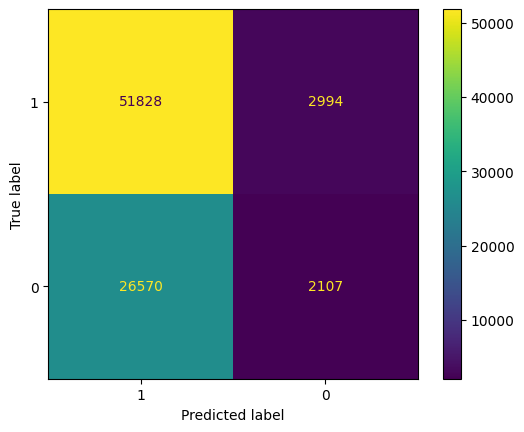

In [51]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred_proba > 0.5)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, 0])
disp.plot()

In [52]:
ebm_perf = ROC(ebm).explain_perf(X_test, y_test, name='EBM')
show(ebm_perf)

In [ ]:
# ebm_local = ebm.explain_local(X_test[:5], y_test[:5], name='EBM')
# show(ebm_local, 0)

In [ ]:
import gamchanger as gc
gc.visualize(ebm, X_test.to_pandas(), y_test.to_pandas())